# IMPORTANT! PLEASE READ

As mentioned in our README.md, the time required to train the model would be very long with laptops without graphical processing units. 
The sections related to training models are section 2,3 and 5.
* Section 2 is for training and collecting metrics for the imbalanced model, used for comparison between 2 datasets.
* Section 3 is for training and collecting metrics for the balanced model, used for comparison between 2 datasets.
* Section 5 is for training the final model, to be used in shiny app.


# 1. Make a classification model

In [2]:
# Importing all libraries
import random
import numpy as np
import pandas as pd
import os
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchmetrics import ConfusionMatrix

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import recall_score, balanced_accuracy_score, precision_score, accuracy_score
from sklearn.model_selection import KFold

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

## 1.2 Data transform and Model architecture

We define a function to transform the image and define the model architecture.

In [3]:
# Resize and turn image to tensor
image_transform = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  transforms.ToTensor()
])

# Make sure result is the same after every run
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Get the device available to use
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

# Model architecture, subclassing nn.Module
class ClassificationModel(nn.Module):
  def __init__(self, input, hidden, output):
    super().__init__()

    # first convolutional block
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input, out_channels=hidden, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # second convolutional block
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # classifier
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden*13*13, out_features=output)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))
  
  def forward_with_shape(self, x):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      x = nn.Flatten()(x)
      return x.shape[1]

## 1.3 Define model training function

In [4]:
def train(model, dataloader, loss_fn, optimizer, device=device):
  # Put to train mode
  model.train()
  for batch, (X, y) in enumerate(dataloader):

    # Use the correct device
    X, y = X.to(device), y.to(device)

    # Pass the data through the model
    y_pred = model(X)

    # Calculate the loss
    loss = loss_fn(y_pred, y)

    # Optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def test(model, dataloader, device=device):
  # Put to evaluation mode
  model.eval()
  with torch.inference_mode():
    y_true = torch.tensor([], dtype=torch.long, device=device)
    y_pred = torch.tensor([], dtype=torch.long, device=device)
    for batch, (X, y) in enumerate(dataloader):
      # Use correct device
      X, y = X.to(device), y.to(device)
      # Pass the data to model
      test_pred_logits = model(X)

      # Get the label
      test_pred_labels = test_pred_logits.argmax(dim=1)
      y_true = torch.cat((y_true, y.detach()), dim=0).to(device)
      y_pred = torch.cat((y_pred, test_pred_labels.detach()), dim=0).to(device)

  # Return the true labels and predictions
  y_true = y_true.cpu().numpy()
  y_pred = y_pred.cpu().detach().numpy()

  return y_true, y_pred


# 2. Imbalanced Data for model training and testing





We first try to use the imbalanced dataset for training and testing.

In [18]:
seed_everything(0)
# Define the path to data
data3888_path = Path("data/data_processed")
imbalanced_data_path = data3888_path/ "cells_renamed_imbalanced"
imbalanced_data = datasets.ImageFolder(root=imbalanced_data_path,transform=image_transform)

# Get a dictionary of labels
cluster_dict = imbalanced_data.class_to_idx

# 5 repeates of 10-fold cv
folds = 10
reps = 5

# Define needed metrics
recall_fold_imbalanced = {key:[] for key in cluster_dict.values()}
precision_fold_imbalanced = {key:[] for key in cluster_dict.values()}
accuracy_fold_imbalanced = []
balanced_accuracy_fold_imbalanced = []

Y_true_imbalanced = []
Y_pred_imbalanced = []

# 5 repeates of CV
rkf = RepeatedKFold(n_splits=folds, n_repeats=reps, random_state=42)
for fold, (train_idx, test_idx) in enumerate(rkf.split(imbalanced_data)):
    if fold % folds == 0:
        print(f"CV {int(fold/10) + 1}/{5}")

    # Subsetting data
    train_subset = Subset(imbalanced_data, train_idx)
    test_subset = Subset(imbalanced_data, test_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    model_imbalanced = ClassificationModel(3,10,len(cluster_dict)).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model_imbalanced.parameters(),lr=0.001)

    # Train for 10 epochs on the training fold
    for epoch in range(10):
        train(model_imbalanced, train_loader, loss_fn, optimizer)
    
    # Test on the testing fold
    y_true, y_pred = test(model_imbalanced, test_loader)
    Y_true_imbalanced.extend(y_true)
    Y_pred_imbalanced.extend(y_pred)

    # Collect metrics
    balanced_accuracy_fold_imbalanced.append(balanced_accuracy_score(y_true,y_pred))
    accuracy_fold_imbalanced.append(accuracy_score(y_true,y_pred))

    recall_per_class = recall_score(y_true, y_pred, labels=list(cluster_dict.values()), average=None, zero_division=0)
    precision_per_class = precision_score(y_true, y_pred, labels=list(cluster_dict.values()), average=None,zero_division=0.0)
    for key in cluster_dict.values():
        precision_fold_imbalanced[key].append(precision_per_class[key])
        recall_fold_imbalanced[key].append(recall_per_class[key])

# Finalize metrics            
accuracy_imbalanced = sum(accuracy_fold_imbalanced) / len(accuracy_fold_imbalanced)
balanced_accuracy_imbalanced = sum(balanced_accuracy_fold_imbalanced) / len(balanced_accuracy_fold_imbalanced)
recall_imbalanced = {key:[] for key in cluster_dict.values()}
for key in cluster_dict.values():
    recall_imbalanced[key] = sum(recall_fold_imbalanced[key]) / len(recall_fold_imbalanced[key])
precision_imbalanced = {key:[] for key in cluster_dict.values()}
for key in cluster_dict.values():
    precision_imbalanced[key] = sum(precision_fold_imbalanced[key]) / len(precision_fold_imbalanced[key])


CV 1/5
CV 2/5
CV 3/5
CV 4/5
CV 5/5


# 3. Balanced data for model training and testing

Now we use the balanced dataset, the same process as above is applied.

In [19]:
# The same process as the imbalanced model, only changing dataset
seed_everything(0)

balanced_data_path = data3888_path/ "cells_renamed_balanced"
balanced_data = datasets.ImageFolder(root=balanced_data_path,transform=image_transform)
cluster_dict = balanced_data.class_to_idx

Y_true_balanced = []
Y_pred_balanced = []

recall_fold_balanced = {key:[] for key in cluster_dict.values()}
precision_fold_balanced = {key:[] for key in cluster_dict.values()}
accuracy_fold_balanced = []
balanced_accuracy_fold_balanced = []

rkf = RepeatedKFold(n_splits=folds, n_repeats=reps, random_state=42)
for fold, (train_idx, test_idx) in enumerate(rkf.split(balanced_data)):
    if fold % folds == 0:
        print(f"CV {int(fold/10) + 1}/{5}")

    train_subset = Subset(balanced_data, train_idx)
    test_subset = Subset(balanced_data, test_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    model_balanced = ClassificationModel(3,10,len(cluster_dict)).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model_balanced.parameters(),lr=0.001)
    for epoch in range(10):
        train(model_balanced, train_loader, loss_fn, optimizer)
    y_true, y_pred = test(model_balanced, test_loader)
    Y_true_balanced.extend(y_true)
    Y_pred_balanced.extend(y_pred)

    balanced_accuracy_fold_balanced.append(balanced_accuracy_score(y_true,y_pred))
    accuracy_fold_balanced.append(accuracy_score(y_true,y_pred))

    recall_per_class = recall_score(y_true, y_pred, labels=list(cluster_dict.values()), average=None, zero_division=0)
    precision_per_class = precision_score(y_true, y_pred, labels=list(cluster_dict.values()), average=None,zero_division=0.0)
    for key in cluster_dict.values():
        precision_fold_balanced[key].append(precision_per_class[key])
        recall_fold_balanced[key].append(recall_per_class[key])
            
accuracy_balanced = sum(accuracy_fold_balanced) / len(accuracy_fold_balanced)
balanced_accuracy_balanced = sum(balanced_accuracy_fold_balanced) / len(balanced_accuracy_fold_balanced)
recall_balanced = {key:[] for key in cluster_dict.values()}
for key in cluster_dict.values():
    recall_balanced[key] = sum(recall_fold_balanced[key]) / len(recall_fold_balanced[key])
precision_balanced = {key:[] for key in cluster_dict.values()}
for key in cluster_dict.values():
    precision_balanced[key] = sum(precision_fold_balanced[key]) / len(precision_fold_balanced[key])



CV 1/5


CV 2/5
CV 3/5
CV 4/5
CV 5/5


We export all the metrics and models to the data/export folder. So that anyone can reproduce our plots without having to train the models all over again.

In [20]:
metric_path = Path("data/export/metrics")
model_path = Path("data/export/models")

torch.save(model_imbalanced, model_path/"model_imbalanced.pt")
torch.save(accuracy_imbalanced,metric_path / "accuracy_imbalanced.pt")
torch.save(recall_imbalanced,metric_path / "recall_imbalanced.pt")
torch.save(precision_imbalanced,metric_path / "precision_imbalanced.pt")
torch.save(balanced_accuracy_imbalanced,metric_path / "balanced_accuracy_imbalanced.pt")
torch.save(Y_pred_imbalanced,metric_path / "Y_pred_imbalanced.pt")
torch.save(Y_true_imbalanced,metric_path / "Y_true_imbalanced.pt")

torch.save(model_balanced, model_path/"model_balanced.pt")
torch.save(accuracy_balanced,metric_path / "accuracy_balanced.pt")
torch.save(recall_balanced,metric_path / "recall_balanced.pt")
torch.save(precision_balanced,metric_path / "precision_balanced.pt")
torch.save(balanced_accuracy_balanced,metric_path / "balanced_accuracy_balanced.pt")
torch.save(Y_pred_balanced,metric_path / "Y_pred_balanced.pt")
torch.save(Y_true_balanced,metric_path / "Y_true_balanced.pt")

# 4 Visualization

We'll have to load in the metrics and models first.

In [6]:
seed_everything(42)
data3888_path = Path("data/data_processed")
imbalanced_data_path = data3888_path/ "cells_renamed_imbalanced"
imbalanced_data = datasets.ImageFolder(root=imbalanced_data_path,transform=image_transform)

balanced_data_path = data3888_path/ "cells_renamed_balanced"
balanced_data = datasets.ImageFolder(root=balanced_data_path,transform=image_transform)
# Get a dictionary of labels
cluster_dict = imbalanced_data.class_to_idx

folds = 10
reps = 5

metric_path = Path("data/export/metrics")
model_path = Path("data/export/models")

model_imbalanced = torch.load(model_path/"model_imbalanced.pt", map_location=torch.device(device))
accuracy_imbalanced = torch.load(metric_path / "accuracy_imbalanced.pt", map_location=torch.device(device))
recall_imbalanced = torch.load(metric_path / "recall_imbalanced.pt", map_location=torch.device(device))
precision_imbalanced = torch.load(metric_path / "precision_imbalanced.pt", map_location=torch.device(device))
balanced_accuracy_imbalanced = torch.load(metric_path / "balanced_accuracy_imbalanced.pt", map_location=torch.device(device))
Y_pred_imbalanced = torch.load(metric_path / "Y_pred_imbalanced.pt", map_location=torch.device(device))
Y_true_imbalanced = torch.load(metric_path / "Y_true_imbalanced.pt", map_location=torch.device(device))

model_balanced = torch.load(model_path/"model_balanced.pt", map_location=torch.device(device))
accuracy_balanced = torch.load(metric_path / "accuracy_balanced.pt", map_location=torch.device(device))
recall_balanced = torch.load(metric_path / "recall_balanced.pt", map_location=torch.device(device))
precision_balanced = torch.load(metric_path / "precision_balanced.pt", map_location=torch.device(device))
balanced_accuracy_balanced = torch.load(metric_path / "balanced_accuracy_balanced.pt", map_location=torch.device(device))
Y_pred_balanced = torch.load(metric_path / "Y_pred_balanced.pt", map_location=torch.device(device))
Y_true_balanced = torch.load(metric_path / "Y_true_balanced.pt", map_location=torch.device(device))

Let's first have a look at the distribution of different classes between the imbalanced and balanced dataset. Please note that we label clusters with missing corresponding groups as Emp (short for Empty).

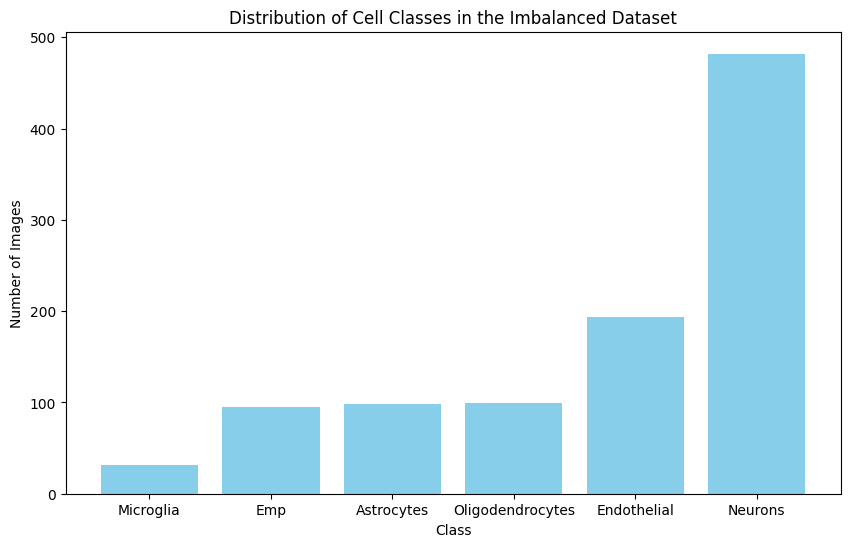

In [7]:
classes = [d for d in os.listdir(imbalanced_data_path) if os.path.isdir(os.path.join(imbalanced_data_path, d))]
class_counts = Counter()

# Counting instances of each class
for cls in classes:
    class_path = os.path.join(imbalanced_data_path, cls)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[cls] = num_images

# Sort classes and counts by the number of images in ascending order
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1]))
labels, counts = zip(*sorted_class_counts.items())

# Bar plot of distribution
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Cell Classes in the Imbalanced Dataset')

# Save the plot to figures directory
figure_directory = "figures"
output_filename = "Distribution of Cell Classes in the Imbalanced Dataset.png"
output_path = os.path.join(figure_directory, output_filename)
plt.savefig(output_path)

plt.show()

The Neurons class has the highest number of images, significantly more than any other class, with nearly 500 images.

Endothelial cells have the second-highest number of images, around 200.

Astrocytes, Emp, and Oligodendrocytes have a moderate count, each having about 100 images.

Microglia have the fewest images, significantly lower than others, with fewer than 50 images.

Lets examine the balanced set, though we know for sure each class of this on would have exactly 500 images.

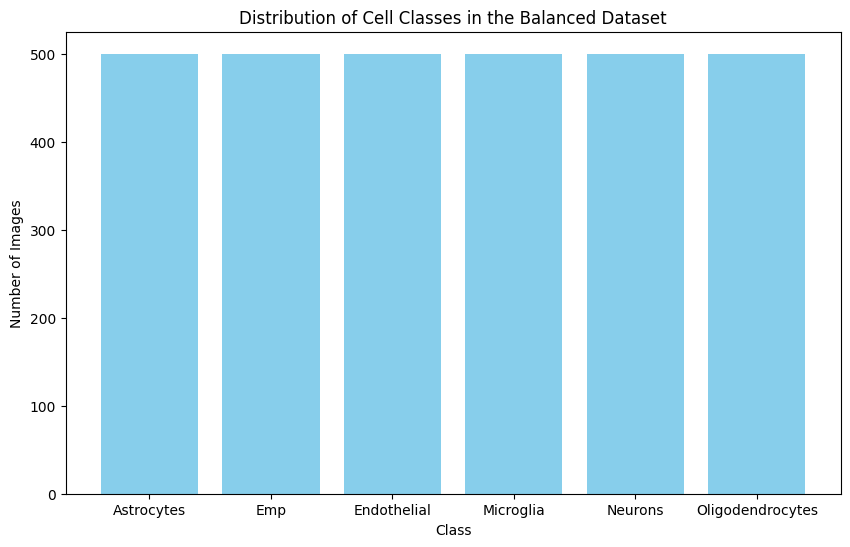

In [8]:
class_counts = Counter()
for cls in classes:
    class_path = os.path.join(balanced_data_path, cls)
    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[cls] = num_images

labels, counts = zip(*class_counts.items())

# bar plot of distribution
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Cell Classes in the Balanced Dataset')

# Save the plot to figures directory
figure_directory = "figures"
output_filename = "Distribution of Cell Classes in the Balanced Dataset.png"
output_path = os.path.join(figure_directory, output_filename)
plt.savefig(output_path)

plt.show()

All classes have 500 images in the balanced set.

## 4.1 Confusion Matrix

For each fold in the cross validation process, we save the true labels and predicted labels from the model. Thus, we now have the confusion matrix for the whole dataset for both balanced and imbalanced dataset.

We examine the confusion matrix of the imbalanced dataset first. The decimals are results of dividing each entry of the original confusion matrix by the number of repeats of cross validation (5) as explained in our report.

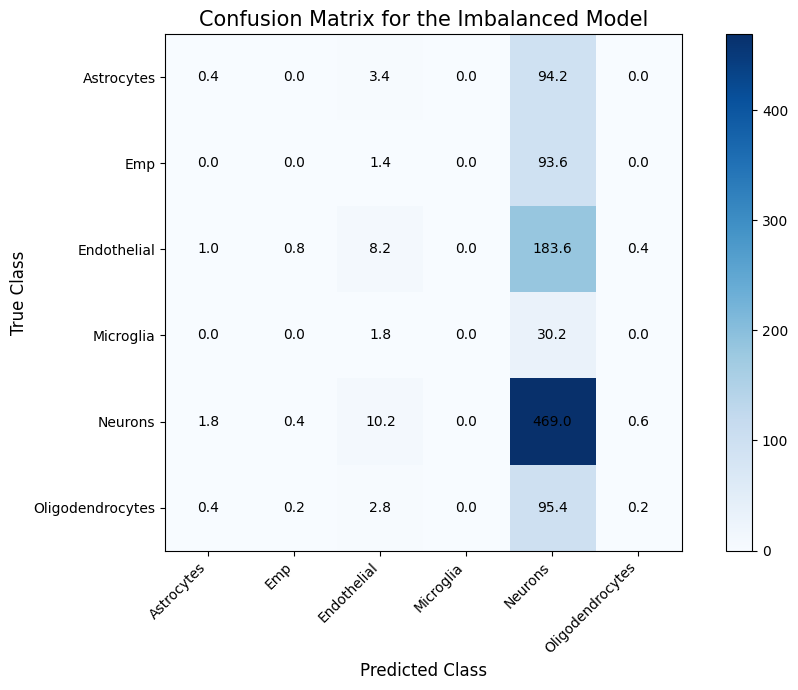

In [9]:
seed_everything(42)
class_names = list(cluster_dict.keys())

# Turn list to tensor
y_pred_tensor_imbalanced = torch.tensor(Y_pred_imbalanced)
y_true_tensor_imbalanced = torch.tensor(Y_true_imbalanced)

# Creating the matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor_imbalanced = confmat(preds=y_pred_tensor_imbalanced, target=y_true_tensor_imbalanced)
# Divide each entry by 5
confmat_tensor_imbalanced = confmat_tensor_imbalanced.float() / reps

# Formating the matrix
fig, ax = plt.subplots(figsize=(10, 7))
conf_matrix = confmat_tensor_imbalanced.numpy()

cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)

ax.set_xlabel("Predicted Class", fontsize=12)
ax.set_ylabel("True Class", fontsize=12)
ax.set_title("Confusion Matrix for the Imbalanced Model", fontsize=15)
ax.xaxis.tick_bottom()

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

# Keep 1 decimal point
for (i, j), val in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{val:.1f}', ha='center', va='center', color='black')

plt.tight_layout()

# Save the plot to figures directory
figure_directory = "figures"
output_filename = "Figure 1 Confusion Matrix for the Imbalanced Model.png"
output_path = os.path.join(figure_directory, output_filename)
plt.savefig(output_path)

plt.show()

 The model predicts Neurons with high accuracy. There are significant misclassifications for other labels, with many instances incorrectly predicted as Neurons. The model’s tendency to predict Neurons, regardless of the true class, suggests a bias towards the most frequent class in the imbalanced dataset. The model’s predictive performance is skewed, which could lead to unreliable predictions in real-world scenarios.

Now we visualize the confusion matrix for the balanced dataset.

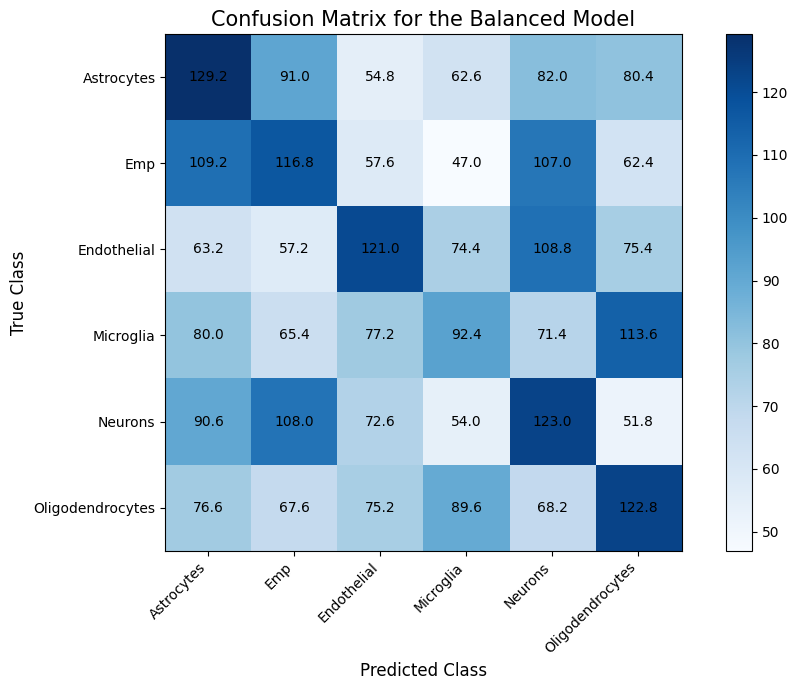

In [10]:
# The same process as above
y_pred_tensor_balanced = torch.tensor(Y_pred_balanced)
y_true_tensor_balanced = torch.tensor(Y_true_balanced)

confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor_balanced = confmat(preds=y_pred_tensor_balanced, target=y_true_tensor_balanced)
confmat_tensor_balanced = confmat_tensor_balanced.float() / reps

fig, ax = plt.subplots(figsize=(10, 7))
conf_matrix = confmat_tensor_balanced.numpy()

cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)

ax.set_xlabel("Predicted Class", fontsize=12)
ax.set_ylabel("True Class", fontsize=12)
ax.set_title("Confusion Matrix for the Balanced Model", fontsize=15)
ax.xaxis.tick_bottom()

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

for (i, j), val in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{val:.1f}', ha='center', va='center', color='black')

plt.tight_layout()

# Save the plot to figures directory
figure_directory = "figures"
output_filename = "Figure 2 Confusion Matrix for the Balanced Model.png"
output_path = os.path.join(figure_directory, output_filename)
plt.savefig(output_path)

plt.show()

The values across the matrix are relatively even, indicating a balanced distribution of predictions across all classes. Higher values along the diagonal suggest correct predictions, with the model performing well for most classes. 
This confusion matrix reflects a model that is performing well on a balanced dataset, with a good distribution of correct predictions across all classes. 

## 4.2 Saliency plot

We chose an image to pass through the model, and visualize pixels that are important to the both models prediction.

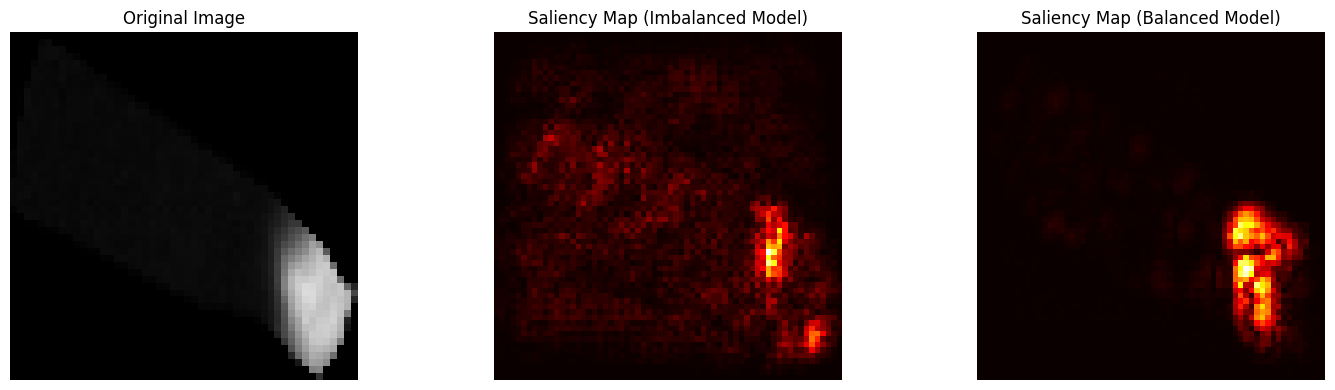

In [17]:
seed_everything(42)
# Load the image as a NumPy array
random_image_path = Path('data/data_processed/cells_renamed_imbalanced/Astrocytes/18287.png')
img1 = cv2.imread(str(random_image_path))
img2 = np.zeros((50, 50, 3), dtype=np.uint8)

img2[:,:,0] = img1[:,:,0] 
pil_img = Image.fromarray(img2)

# Transform the image for the model
input_img = image_transform(pil_img).unsqueeze(0).to(device)
input_img.requires_grad_(True)

# Create a function to get the saliency map from a model
def get_saliency_map(model, input_img):
    model.eval()
    output = model(input_img)
    output_idx = output.argmax()
    output_max = output[0, output_idx]
    output_max.backward()
    saliency, _ = torch.max(input_img.grad.data.abs(), dim=1)
    return saliency

# Get saliency maps from both models
saliency_imbalanced = get_saliency_map(model_imbalanced, input_img)
saliency_balanced = get_saliency_map(model_balanced, input_img)

# Plot the original image and the saliency maps
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Original image
axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Saliency map for imbalanced model
axs[1].imshow(saliency_imbalanced[0].cpu(), cmap='hot')
axs[1].set_title('Saliency Map (Imbalanced Model)')
axs[1].axis('off')

# Saliency map for balanced model
axs[2].imshow(saliency_balanced[0].cpu(), cmap='hot')
axs[2].set_title('Saliency Map (Balanced Model)')
axs[2].axis('off')

plt.tight_layout()

# Save the plot to figures directory
figure_directory = "figures"
output_filename = "Figure 5 Saliency Plot.png"
output_path = os.path.join(figure_directory, output_filename)
plt.savefig(output_path)

plt.show()

## 4.3 Accuracy and Balanced Accuracy

To visualize this comparison between the 2 models, we present a barplot showcasing the accuracy and balanced accuracy scores of the imbalanced and balanced models. 


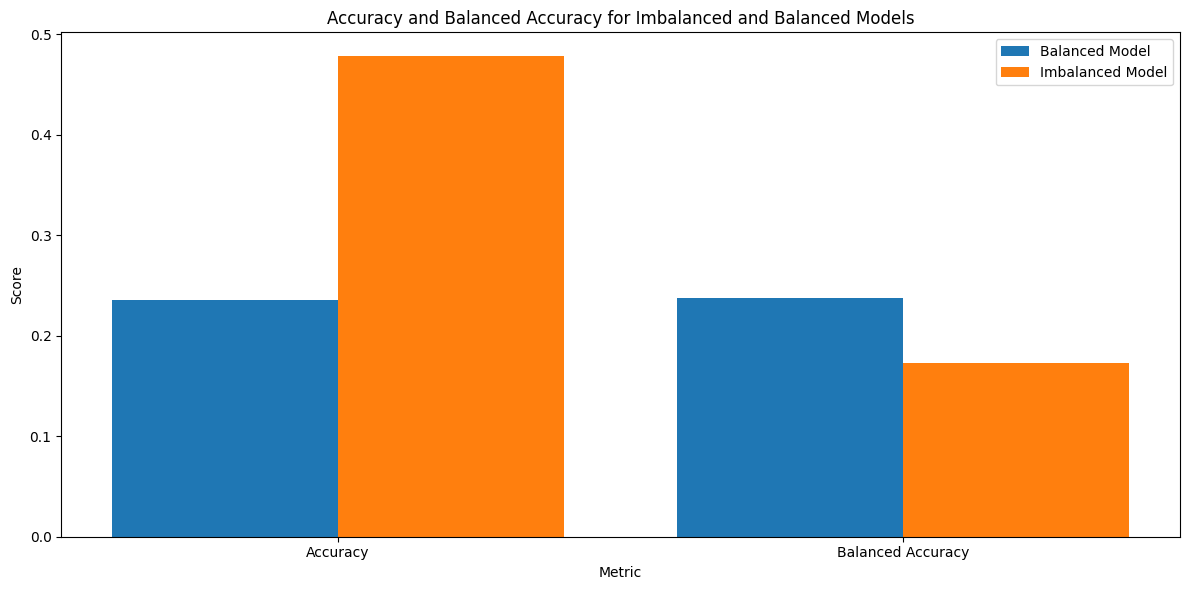

In [11]:
# Data for the plots
accuracies = [accuracy_imbalanced, accuracy_balanced]
balanced_accuracies = [balanced_accuracy_imbalanced, balanced_accuracy_balanced]
labels = ['Accuracy', 'Balanced Accuracy']

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Define the positions of the bars
index = np.arange(2) 
bar_width = 0.4

# Plot the bars
bar1 = ax.bar(index, [accuracies[1], balanced_accuracies[1]], bar_width, label='Balanced Model', color='tab:blue')
bar2 = ax.bar(index + bar_width, [accuracies[0], balanced_accuracies[0]], bar_width, label='Imbalanced Model', color='tab:orange')  # Adjusted position

# Add labels, title, and legend
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Accuracy and Balanced Accuracy for Imbalanced and Balanced Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

# Adjust layout
plt.tight_layout()

# Save the plot to figures directory
figure_directory = "figures"
output_filename = "Accuracy and Balanced Accuracy for Imbalanced and Balanced Models.png"
output_path = os.path.join(figure_directory, output_filename)
plt.savefig(output_path)

plt.show()



The accuracy of the imbalanced model is only higher than that of the balanced model due to the huge number of neurons existing in the imbalanced dataset.
The balanced model shows a better balanced accuracy, which makes sense since balanced accuracy gives equal weight to each class, providing a more accurate representation of the model's performance across all classes.

## 4.4 Recall

Lets see the  recall for each class between the imbalanced and balanced dataset.

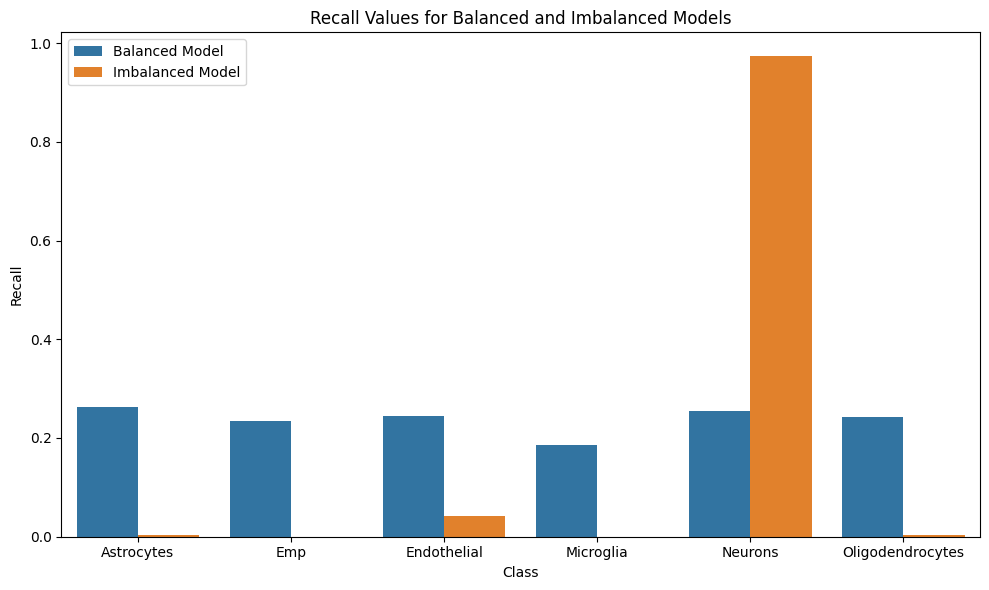

In [12]:
# get a dataframe
data = []
classes = list(class_names)
for key in recall_balanced:
    data.append({"Class": classes[key], "Recall": recall_balanced[key], "Condition": "Balanced Model"})
    data.append({"Class": classes[key], "Recall": recall_imbalanced[key], "Condition": "Imbalanced Model"})

df = pd.DataFrame(data)

# plot the barplot
plt.figure(figsize=(10, 6))
sns.barplot(x="Class", y="Recall", hue="Condition", data=df)
plt.title("Recall Values for Balanced and Imbalanced Models")
plt.ylabel("Recall")
plt.xlabel("Class")
plt.legend(title="")
plt.tight_layout()

# Save the plot to figures directory
figure_directory = "figures"
output_filename = "Figure 3 Recall Values for Balanced and Imbalanced Models.png"
output_path = os.path.join(figure_directory, output_filename)
plt.savefig(output_path)

plt.show()

The balanced model appears to provide more equitable recall across different classes, which is often desired in applications requiring fair representation, unlike the imbalanced model, which only focuses on Neurons.

## 4.5 Precision

Lets see the precision for each class between the imbalanced and balanced dataset.

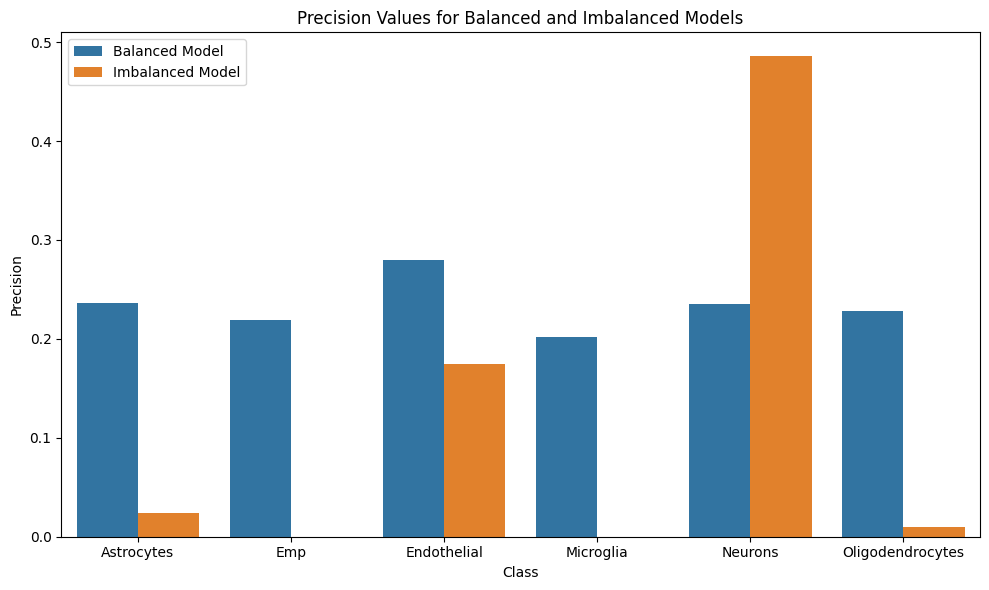

In [13]:
# same process as recall plotting
data = []
classes = list(class_names)
for key in precision_balanced:
    data.append({"Class": classes[key], "Precision": precision_balanced[key], "Condition": "Balanced Model"})
    data.append({"Class": classes[key], "Precision": precision_imbalanced[key], "Condition": "Imbalanced Model"})

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(x="Class", y="Precision", hue="Condition", data=df)
plt.title("Precision Values for Balanced and Imbalanced Models")
plt.ylabel("Precision")
plt.xlabel("Class")
plt.legend(title="")
plt.tight_layout()

# Save the plot to figures directory
figure_directory = "figures"
output_filename = "Figure 4 Precision Values for Balanced and Imbalanced Models.png"
output_path = os.path.join(figure_directory, output_filename)
plt.savefig(output_path)

plt.show()

Imbalanced Model: The precision values for the imbalanced model are low for each label, except for Neurons.

Balanced Model: The balanced model shows overall higher precision values represented by bars for each label.

Balancing the dataset seems to have generally improved precision across most classes, which is expected as balancing helps the model to not develop bias toward the dominant class.

# 5. Train the final model

From the sections above, we have decided to use all the balanced dataset to train the final model. 

In [30]:
seed_everything(42)
# Using all the balanced dataset for training 
train_data_final = datasets.ImageFolder(root=balanced_data_path, transform=image_transform, target_transform=None)
train_dataloader_final = DataLoader(dataset=train_data_final, batch_size=32, num_workers=1, shuffle=True)

model_final = ClassificationModel(3, 10, len(cluster_dict))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_final.parameters(), lr=0.001)

# Train for 10 epochs
for epoch in range(10):
  train(model_final, train_dataloader_final, loss_fn, optimizer,device="cpu")

The code below export the final model to the model folder, from which the Shiny app can access it.

In [31]:
# Save the model to the shiny_app directory
shiny_path = Path("shiny_app/balanced_model_state.pth")

torch.save(model_final.state_dict(),shiny_path)
